In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from diffusion_equation import compute_solution
from time import time
from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score

# todo: add pwat, poil, kwat, koil to model and train on different datsets


# Getting data from simulator

In [2]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [3]:
nx0, nx1

(64, 64)

In [4]:
# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, t_final, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

# x_list = np.random.randint(size=niter, low=0, high=64)
# y_list = np.random.randint(size=niter, low=0, high=64)
# dt_n = np.random.randint(size=niter, low=0, high=niter)

# # 0 - pres, 1 - swat, 2 - soil
# sim_data = np.zeros((niter, 3))

# # simulation
# for i in trange(niter):
#     sim_data[i, 0] = pres[x_list[i], y_list[i], 0, dt_n[i]]
#     sim_data[i, 1] = swat[x_list[i], y_list[i], 0, dt_n[i]]
#     sim_data[i, 2] = soil[x_list[i], y_list[i], 0, dt_n[i]]

# #   saving data in file
# N = niter
# np.savetxt(f"data_5k_200225/sim_{N}.txt", sim_data)
# np.savetxt(f"data_5k_200225/x_{N}.txt", x_list)
# np.savetxt(f"data_5k_200225/y_{N}.txt", y_list)
# np.savetxt(f"data_5k_200225/t_{N}.txt", dt_n)

In [5]:
# configuration of simulator
# # and parametrs of reservouir
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3


# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
# dt = 3.0 / 2000
# niter = 2000

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.ones((nx0, nx1, nx2))

# Read from file

In [6]:
np.random.randint(0, 5000, 2000)

array([3100, 4740,  217, ..., 1197, 4406,  577], shape=(2000,))

In [7]:
# sim_data: pres, swat, soil

# # 2000
# sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
# x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
# y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
# t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list
n_points = 500
sim_r = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_200225/sim_5000.txt", dtype=np.float32)[sim_r]
x_list = np.loadtxt("data_5k_200225/x_5000.txt", dtype=np.float32)[sim_r]
y_list = np.loadtxt("data_5k_200225/y_5000.txt", dtype=np.float32)[sim_r]
t_list = np.loadtxt("data_5k_200225/t_5000.txt", dtype=np.float32)[sim_r]
sim_data, x_list, y_list, t_list

(array([[ 5.0263710e-02,  3.4697067e-34,  1.0000000e+00],
        [ 2.3657091e-01, -2.8221856e-34,  1.0000000e+00],
        [ 8.7703514e-01,  4.3366867e-06,  9.9999565e-01],
        ...,
        [ 9.5221674e-01,  3.8329798e-01,  6.1670202e-01],
        [ 4.6932611e-01,  7.7849758e-34,  1.0000000e+00],
        [ 8.1350291e-01,  1.1135675e-16,  1.0000000e+00]],
       shape=(500, 3), dtype=float32),
 array([55., 43., 10., 54., 25., 24., 48., 30., 33., 49., 21., 40.,  4.,
        16., 61., 11., 54.,  5., 50., 35.,  7.,  6.,  7., 56., 23., 37.,
        53., 60., 31., 39., 18., 28., 49.,  9., 38., 51., 36., 13., 23.,
        61., 10., 23., 34., 25., 23., 51., 60., 26., 42., 60., 47., 45.,
        25., 56., 11.,  3., 49., 51.,  5., 53.,  6., 54., 10.,  1., 20.,
        39., 34., 25.,  8., 12., 44., 32., 21., 62., 44.,  6., 34.,  7.,
        53., 24., 20., 38., 46., 60., 26., 36., 28., 45.,  6., 60., 60.,
         8., 24., 57., 43., 32., 13., 48., 45., 55., 14., 27., 25., 45.,
        44., 58

In [8]:
sim_data.shape

(500, 3)

In [9]:
perm.shape

(64, 64, 1)

# Convert to torch tensor

In [10]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list * dt).requires_grad_(True)

points = torch.stack((t, x, y), -1).requires_grad_(True)
points, simulation_data

(tensor([[0.7482, 0.8594, 0.2969],
         [0.3006, 0.6719, 0.2031],
         [1.2270, 0.1562, 0.6406],
         ...,
         [2.0268, 0.0312, 0.3281],
         [1.1958, 0.4219, 0.1250],
         [2.6094, 0.2344, 0.2656]], grad_fn=<StackBackward0>),
 tensor([[ 5.0264e-02,  3.4697e-34,  1.0000e+00],
         [ 2.3657e-01, -2.8222e-34,  1.0000e+00],
         [ 8.7704e-01,  4.3367e-06,  1.0000e+00],
         ...,
         [ 9.5222e-01,  3.8330e-01,  6.1670e-01],
         [ 4.6933e-01,  7.7850e-34,  1.0000e+00],
         [ 8.1350e-01,  1.1136e-16,  1.0000e+00]], requires_grad=True))

# Boundary points

In [11]:
pres0_x1_points = torch.stack((t, torch.zeros_like(x), y), -1).requires_grad_(True)
pres1_x1_points = torch.stack((t, torch.ones_like(x), y), -1).requires_grad_(True)
swat0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
soil0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
u0_x2_points = torch.stack((t, x, torch.zeros_like(y)), -1).requires_grad_(True)
u1_x2_points = torch.stack((t, x, torch.ones_like(y)), -1).requires_grad_(True)

# Model configuration

In [12]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 3, hidden_layer = 32, number_layers = 8, output_layer = 7):
        super().__init__()
        
        activation2 = nn.Sigmoid
        activation1 = nn.ReLU
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation1()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation1()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        """
        function for updating neural network
        
        return:
            x - vector (pres
                        soil
                        swat
                        uoil_x,  
                        uoil_y,
                        uwat_x,  
                        uwat_y)
        """
        
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

draft

<!-- 

# Differentiail equations, Loss function difinition

$$k_{water} = 1, k_{oil} = 0.3$$
$$x = (x_1, x_2)$$
$$ \phi(x) = 0.1 (poro)\\
k(x) = 1 (perm)$$

#### System of equation:

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + div(u_{water}) = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + div(u_{oil}) = 0 \\
        r_{3,x_1}(t, x) = u_{\text{water},x_1} + \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{3,x_2}(t, x) = u_{\text{water},x_2} + \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_{4, x_1}(t, x) = u_{\text{oil},x_1} + 0.1 \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{4, x_2}(t, x) = u_{\text{oil},x_2} + 0.1 \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

#### Boundary condition
\begin{equation}
    \begin{cases}
        P(t, (0, x_2)) = (1, 1) \\
        P(t, (1, x_2)) = (0, 0) \\
        s_{\text{water}}(0, x) = (0, 0) \\
        s_{\text{oil}}(0, x) = (1, 1) \\
        u_{water/ oil}^{x_2}(t, x)\big|_{x_2=0} = u_{water/ oil}^{x_2}(t, x)\big|_{x_2=1} = 0
    \end{cases}
\end{equation}


#### Loss function:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2
\end{split}

#### Resultant function:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation} -->

# Model training

In [13]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

loss0_hist = []
loss1_hist = []
loss2_hist = []

w0_hist = []
w1_hist = []
w2_hist = []

In [14]:
# neural network returns:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)

# change learning rate if necessary
optimizer.param_groups[0]['lr'] = 0.0005
perm_vec = torch.tensor(perm[list(x_list.astype(int)), list(y_list.astype(int)), -1])

epochs = 10_000
for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    model_res = model(points).requires_grad_(True)
    # presseru bound
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    
    # struation boundary
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # velocity boundary
    uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
    one_vector = torch.ones_like(model_res[:, 0])
    zeros_vector = torch.zeros_like(model_res[:, 0])
    
    # functions r(t,x)
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    
    r3_x1 = model_res[:, 5] + perm_vec * model_res[:, 2]**2 * (torch.autograd.grad(model_res[:, 0], 
                                                               x, one_vector, 
                                                               create_graph=True)[0])
    
    r3_x2 = model_res[:, 6] + perm_vec * model_res[:, 2]**2 * (torch.autograd.grad(model_res[:, 0], 
                                                               y, one_vector, 
                                                               create_graph=True)[0])

    r4_x1 = model_res[:, 3] + (1/3) * perm_vec * 0.1 * model_res[:, 2]**4 * (torch.autograd.grad(model_res[:, 0], 
                                                                             x, one_vector, 
                                                                             create_graph=True)[0])
    
    r4_x2 = model_res[:, 4] + (1/3) * perm_vec * 0.1 * model_res[:, 2]**4 * (torch.autograd.grad(model_res[:, 0], 
                                                                             y, one_vector, 
                                                                             create_graph=True)[0])
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    
    # Loss0
    loss0 = torch.mean(r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + 
                       r4_x1**2 + r4_x2**2 + r5**2).requires_grad_(True)
    
    # Loss1
    loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
                       (soil0 - one_vector)**2 + swat0**2).requires_grad_(True) 
    # +\
    #                    uwat0_x2**2 + uwat1_x2**2 +\
    #                    uoil0_x2**2 + uoil1_x2**2).requires_grad_(True)

    # x - vector (pres
    #             soil
    #             swat
    #             uoil_x,  
    #             uoil_y,
    #             uwat_x,  
    #             uwat_y)

    # Loss2
    loss2 = torch.mean((model_res[:,0] - simulation_data[:,0])**2 + (model_res[:,2] - simulation_data[:,1])**2 + \
                       (model_res[:,1] - simulation_data[:,2])**2).requires_grad_(True)
    

    # algo for weights adjustment
    l1 = loss1.clone().detach().requires_grad_(True)
    l2 = loss2.clone().detach().requires_grad_(True)
    l0 = loss0.clone().detach().requires_grad_(True)
    l1.backward(retain_graph=True)
    l2.backward(retain_graph=True)
    l0.backward(retain_graph=True)
    w0 = abs(l0 / (l0 + l1 + l2))
    w1 = abs(l1 / (l1 + l0 + l2))
    w2 = abs(l2 / (l1 + l0 + l2))
    
    
    # losses history
    loss0_hist.append(loss0.detach().numpy())
    loss1_hist.append(loss1.detach().numpy())
    loss2_hist.append(loss2.detach().numpy())
    
    #weights history
    w0_hist.append(w0.detach().numpy())
    w1_hist.append(w1.detach().numpy())
    w2_hist.append(w2.detach().numpy())
    
    
    loss = w0*loss0 + w1*loss1 + w2*loss2
    dist = loss0 + loss1 + loss2
    loss.backward(retain_graph=True)
    optimizer.step()
    # if cur_epoch % 3_000:
    #     optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss0.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy())}\t')
#         print(w0, '\t', w1, '\t', w2)

  0%|                                                                                                                | 10/10000 [00:00<03:18, 50.42it/s]

epoch: 0	loss: (3.7297463838056046, 0.6242771569684464, 1.915637731552124, 1.1898314952850342)	


  3%|██▉                                                                                                            | 263/10000 [00:03<02:05, 77.36it/s]

epoch: 250	loss: (0.0859703813024635, 0.015081070391165696, 0.02379835955798626, 0.04709095135331154)	


  5%|█████▋                                                                                                         | 510/10000 [00:06<02:01, 77.90it/s]

epoch: 500	loss: (0.012155445784739316, 0.002099138827472091, 0.0016386084025725722, 0.008417698554694653)	


  8%|████████▍                                                                                                      | 762/10000 [00:09<02:00, 76.56it/s]

epoch: 750	loss: (0.004662119770193556, 0.0009396109830160523, 0.0008877468062564731, 0.00283476198092103)	


 10%|███████████                                                                                                   | 1009/10000 [00:13<01:58, 75.79it/s]

epoch: 1000	loss: (0.003250448706694312, 0.0006648298917751678, 0.0006331788026727736, 0.0019524400122463703)	


 13%|█████████████▉                                                                                                | 1262/10000 [00:16<01:53, 76.76it/s]

epoch: 1250	loss: (0.0028215137548914075, 0.0005935569183139029, 0.0005351206636987627, 0.0016928361728787422)	


 15%|████████████████▋                                                                                             | 1513/10000 [00:20<01:50, 76.57it/s]

epoch: 1500	loss: (0.002469713350267479, 0.0005175072164026591, 0.00048467889428138733, 0.0014675272395834327)	


 18%|███████████████████▍                                                                                          | 1762/10000 [00:23<01:44, 78.81it/s]

epoch: 1750	loss: (0.002267409240607977, 0.0005613025359482171, 0.00042825727723538876, 0.0012778494274243712)	


 20%|██████████████████████▏                                                                                       | 2016/10000 [00:26<01:48, 73.74it/s]

epoch: 2000	loss: (0.002063972059121481, 0.0005564204460905258, 0.0004058077174704522, 0.001101743895560503)	


 23%|████████████████████████▉                                                                                     | 2262/10000 [00:30<01:44, 73.88it/s]

epoch: 2250	loss: (0.001820674703233816, 0.0004888409881488758, 0.000355442869476974, 0.0009763908456079662)	


 25%|███████████████████████████▌                                                                                  | 2510/10000 [00:33<01:34, 79.34it/s]

epoch: 2500	loss: (0.001708327374339518, 0.000481203711510119, 0.00033689418341964483, 0.0008902294794097543)	


 28%|██████████████████████████████▍                                                                               | 2765/10000 [00:36<01:32, 78.48it/s]

epoch: 2750	loss: (0.00163091739593256, 0.000488580321662088, 0.00034293541102670133, 0.0007994016632437706)	


 30%|█████████████████████████████████▏                                                                            | 3013/10000 [00:39<01:28, 79.03it/s]

epoch: 3000	loss: (0.001605387362910808, 0.0004895170792270461, 0.0003229623252991587, 0.0007929079583846033)	


 33%|███████████████████████████████████▊                                                                          | 3258/10000 [00:43<01:23, 80.36it/s]

epoch: 3250	loss: (0.0015814169712617138, 0.00048636212547040376, 0.0003243157407268882, 0.0007707391050644219)	


 35%|██████████████████████████████████████▋                                                                       | 3515/10000 [00:46<01:25, 76.21it/s]

epoch: 3500	loss: (0.0015247219375244694, 0.00046876613799514056, 0.0003137477033305913, 0.0007422080961987376)	


 38%|█████████████████████████████████████████▎                                                                    | 3761/10000 [00:49<01:19, 78.90it/s]

epoch: 3750	loss: (0.0014689185663272425, 0.00045062917700566205, 0.0003058428701478988, 0.0007124465191736817)	


 40%|████████████████████████████████████████████▏                                                                 | 4013/10000 [00:52<01:18, 76.12it/s]

epoch: 4000	loss: (0.0014133262980223465, 0.0004244405086112041, 0.0002974527596961707, 0.0006914330297149718)	


 43%|██████████████████████████████████████████████▊                                                               | 4259/10000 [00:55<01:13, 78.09it/s]

epoch: 4250	loss: (0.0013623111259338807, 0.000411575743430982, 0.00029028384597040713, 0.0006604515365324914)	


 45%|█████████████████████████████████████████████████▌                                                            | 4511/10000 [00:59<01:09, 78.60it/s]

epoch: 4500	loss: (0.0013125869040879843, 0.0004003149110860614, 0.00027912520454265177, 0.0006331467884592712)	


 48%|████████████████████████████████████████████████████▍                                                         | 4763/10000 [01:02<01:08, 76.62it/s]

epoch: 4750	loss: (0.0012831524217659087, 0.000394806454951823, 0.00027493954985402524, 0.0006134064169600606)	


 50%|███████████████████████████████████████████████████████                                                       | 5009/10000 [01:05<01:03, 79.22it/s]

epoch: 5000	loss: (0.0012521477136002014, 0.0003722567878835926, 0.00027191609842702746, 0.0006079748272895813)	


 53%|█████████████████████████████████████████████████████████▊                                                    | 5261/10000 [01:08<01:01, 77.57it/s]

epoch: 5250	loss: (0.0011966597709055287, 0.0003496654577269447, 0.00026416374021209776, 0.0005828305729664862)	


 55%|████████████████████████████████████████████████████████████▋                                                 | 5515/10000 [01:12<00:57, 78.04it/s]

epoch: 5500	loss: (0.001151768589055995, 0.0003551568772074677, 0.0002471387851983309, 0.0005494729266501963)	


 58%|███████████████████████████████████████████████████████████████▎                                              | 5761/10000 [01:15<00:54, 78.27it/s]

epoch: 5750	loss: (0.0011699961899874448, 0.00032728031450898347, 0.00027001669513992965, 0.0005726991803385317)	


 60%|██████████████████████████████████████████████████████████████████▏                                           | 6012/10000 [01:18<00:51, 77.36it/s]

epoch: 6000	loss: (0.0011644091416877513, 0.0003632707364653055, 0.0002450707252137363, 0.0005560676800087094)	


 63%|████████████████████████████████████████████████████████████████████▉                                         | 6265/10000 [01:21<00:48, 76.29it/s]

epoch: 6250	loss: (0.0011040226775256134, 0.00033458304393916953, 0.00024020818818826228, 0.0005292314453981817)	


 65%|███████████████████████████████████████████████████████████████████████▌                                      | 6510/10000 [01:25<00:45, 77.35it/s]

epoch: 6500	loss: (0.0010709062171034896, 0.0003360997925145933, 0.0002328260598005727, 0.0005019803647883236)	


 68%|██████████████████████████████████████████████████████████████████████████▎                                   | 6760/10000 [01:28<00:43, 74.20it/s]

epoch: 6750	loss: (0.0010468939294549593, 0.00032618046724004225, 0.00023547472665086389, 0.00048523873556405306)	


 70%|█████████████████████████████████████████████████████████████████████████████▏                                | 7013/10000 [01:31<00:39, 76.21it/s]

epoch: 7000	loss: (0.0010211870834038383, 0.00032106575994219407, 0.00022388370416592807, 0.0004762376192957163)	


 73%|███████████████████████████████████████████████████████████████████████████████▉                              | 7264/10000 [01:35<00:37, 72.87it/s]

epoch: 7250	loss: (0.0009994434298948862, 0.0003129858164118148, 0.0002220526512246579, 0.00046440496225841343)	


 75%|██████████████████████████████████████████████████████████████████████████████████▋                           | 7512/10000 [01:38<00:32, 76.66it/s]

epoch: 7500	loss: (0.0009843194406781019, 0.00030508774077274355, 0.0002206420322181657, 0.00045858966768719256)	


 78%|█████████████████████████████████████████████████████████████████████████████████████▍                        | 7762/10000 [01:41<00:31, 71.65it/s]

epoch: 7750	loss: (0.0009621308619218635, 0.0003008504628498795, 0.00021198949252720922, 0.00044929090654477477)	


 80%|████████████████████████████████████████████████████████████████████████████████████████▏                     | 8016/10000 [01:45<00:24, 79.98it/s]

epoch: 8000	loss: (0.0009778176761063109, 0.0003102936322864437, 0.00021084347099531442, 0.00045668057282455266)	


 83%|██████████████████████████████████████████████████████████████████████████████████████████▊                   | 8259/10000 [01:48<00:22, 77.15it/s]

epoch: 8250	loss: (0.0009410807343866399, 0.0002933305460229239, 0.00020160269923508167, 0.00044614748912863433)	


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▋                | 8515/10000 [01:51<00:19, 76.90it/s]

epoch: 8500	loss: (0.000995833983462718, 0.00030475570033718324, 0.00022943018120713532, 0.00046164810191839933)	


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8759/10000 [01:55<00:16, 74.17it/s]

epoch: 8750	loss: (0.0009741091678722114, 0.0002955112475307942, 0.0002160324074793607, 0.0004625655128620565)	


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9009/10000 [01:58<00:14, 67.47it/s]

epoch: 9000	loss: (0.0009458487949079345, 0.00030485522085581674, 0.00020007621787954122, 0.00044091735617257655)	


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9261/10000 [02:02<00:09, 75.20it/s]

epoch: 9250	loss: (0.0009527663723833473, 0.0003076557850267352, 0.00021094540716148913, 0.00043416518019512296)	


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9514/10000 [02:05<00:06, 73.58it/s]

epoch: 9500	loss: (0.0009550277149843558, 0.00030479406766393624, 0.00021198519971221685, 0.0004382484476082027)	


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9765/10000 [02:08<00:03, 76.25it/s]

epoch: 9750	loss: (0.0009428600622355112, 0.0002899283006568545, 0.00021201068011578172, 0.000440921081462875)	


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:11<00:00, 75.77it/s]


In [15]:
dist

tensor(0.0010, dtype=torch.float64, grad_fn=<AddBackward0>)

In [16]:
# def main(model):
#     pwat = 2.0
#     poil = 4.0
#     vr = 0.3
#     kwat = 1.0
#     koil = 0.3

#     # pwat = 1.0
#     # poil = 1.0
#     # vr = 1.0
#     # kwat = 1.0
#     # koil = 1.0
#     pmin = 0.0
#     pmax = 1.0
#     nx0 = 50
#     nx1 = 30
#     nx2 = 1
#     dx0 = 1.0 / nx0
#     dx1 = 1.0 / nx1
#     dx2 = 1.0 / nx2
#     dt = 0.26e-1
#     niter = 100

#     poro = 0.1 + np.zeros((nx0, nx1, nx2))
#     perm = np.ones((nx0, nx1, nx2))
#     swat = np.zeros((nx0, nx1, nx2))
#     soil = np.ones((nx0, nx1, nx2))


#     pres, swat, soil = compute_solution(perm, poro,
#                                         dx0, dx1, dx2, dt * niter, niter,
#                                         pwat, kwat, poil, koil, vr,
#                                         pmin=0.0, pmax=1.0)
    
#     time_for_model = (niter * dt) * torch.ones(1500)
#     x_for_model = dx0 * torch.arange(50)
#     y_for_model = dx1 * torch.arange(30)
#     cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
#     model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
#     model_prediction = model_prediction.detach().numpy()
    
    
    
#     plt.figure()
#     plt.title('Water saturation, simulator')
#     plt.imshow(swat[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_sim.png', facecolor='b')
#     plt.show()
    
#     plt.figure()
#     plt.title('Water saturation, PINN')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_pinn.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Pressure, simulator')
#     plt.imshow(pres[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_sim.png')
#     plt.show()
    

#     plt.figure()
#     plt.title('Pressure, PINN')
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_pinn.png')
#     plt.show()    
    
    
#     plt.figure()
#     plt.title('Насыщенность воды')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Модель')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('swat_scatter.png')
#     plt.show()


#     plt.figure()
#     plt.title('Pressure')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Симулятор')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('pres_scatter.png')
#     plt.show()



#     return 0

In [17]:
# main(model)

In [18]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [27]:
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar

def main_new(model):
    set_big_plot_style(scale=1.3)
    perm = np.load('perm.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    pmin = 0.0
    pmax = 1.0

    dt = 0.26e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()
    
    swat_sim_2d = np.squeeze(swat[:, :, 0, -1])   # (nx0, nx1)
    pres_sim_2d = np.squeeze(pres[:, :, 0, -1])   # (nx0, nx1)

    swat_pinn_2d = np.squeeze(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, :, 0])
    pres_pinn_2d = np.squeeze(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, :, 0])

    
    plt.figure()
    plt.title('Water saturation, sim')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('second_test/color_swat_sim.png', bbox_inches="tight")
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, PINN')
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('second_test/color_swat_pinn.png', bbox_inches="tight")
    plt.show()
    
    plt.figure()
    plt.title('Pressure, sim')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('second_test/color_pressure_sim.png', bbox_inches="tight")
    plt.show()
    

    plt.figure()
    plt.title('Pressure, PINN')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('second_test/color_pressure_pinn.png', bbox_inches="tight")
    plt.show()    
    
    
    plt.figure()
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.legend()
    plt.savefig('second_test/swat_scatter.png', bbox_inches="tight")
    plt.show()


    plt.figure()
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.legend()
    plt.savefig('second_test/pres_scatter.png', bbox_inches="tight")
    plt.show()

    return 0

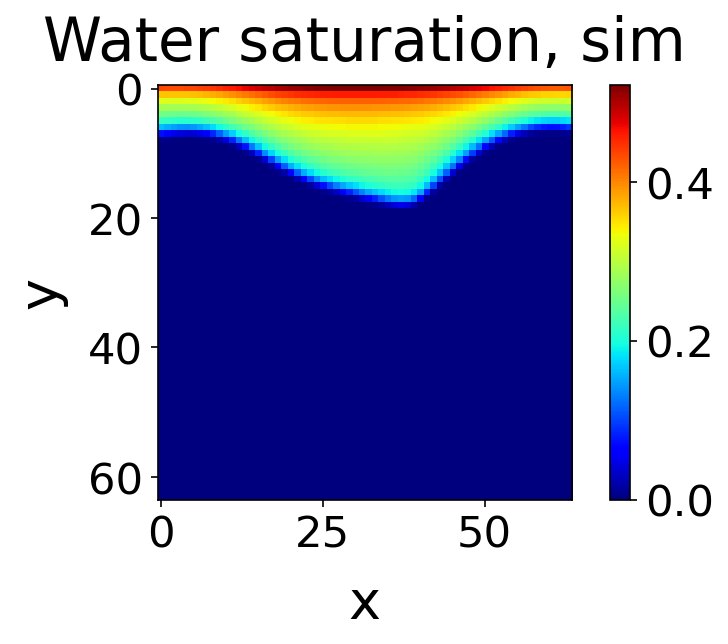

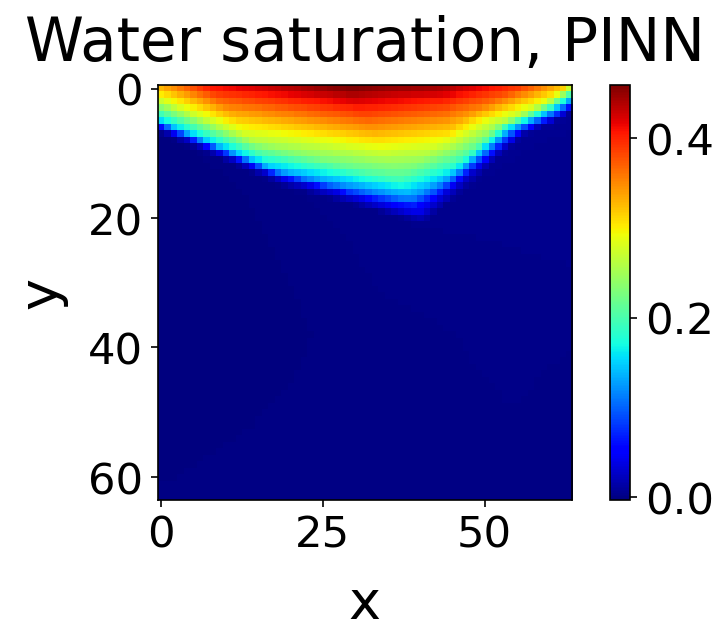

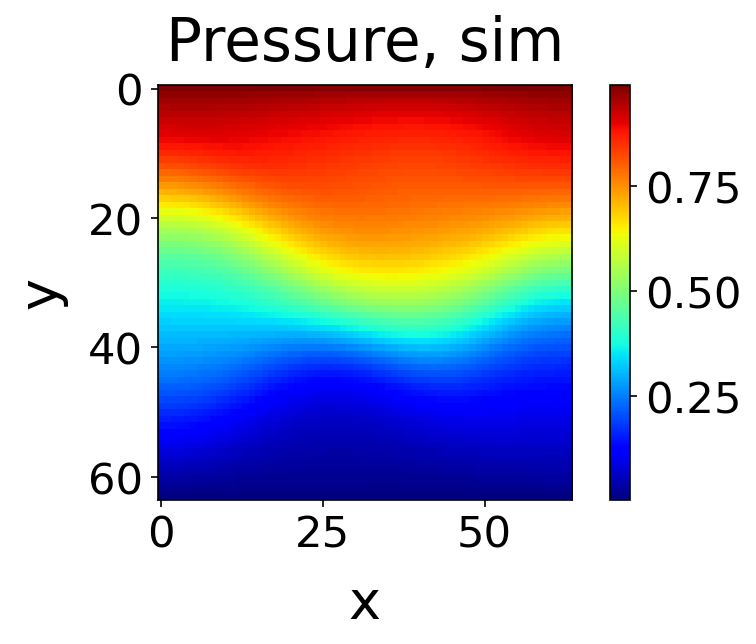

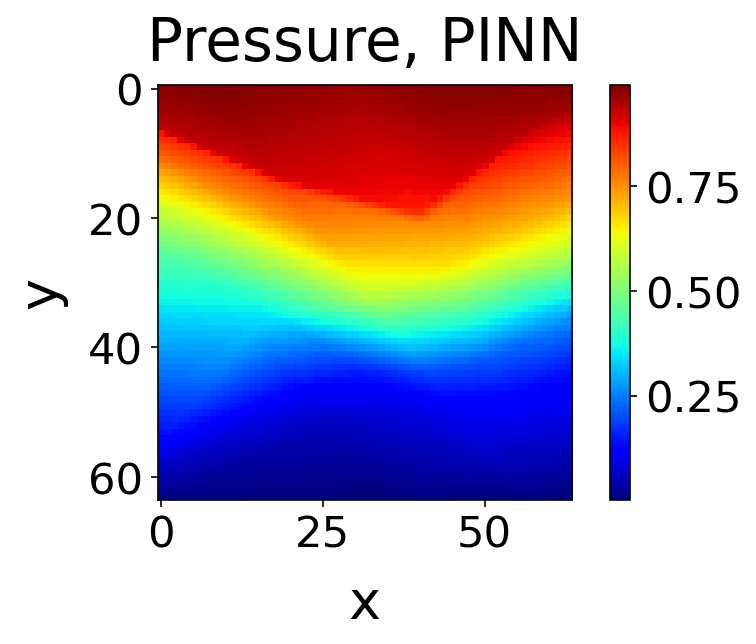

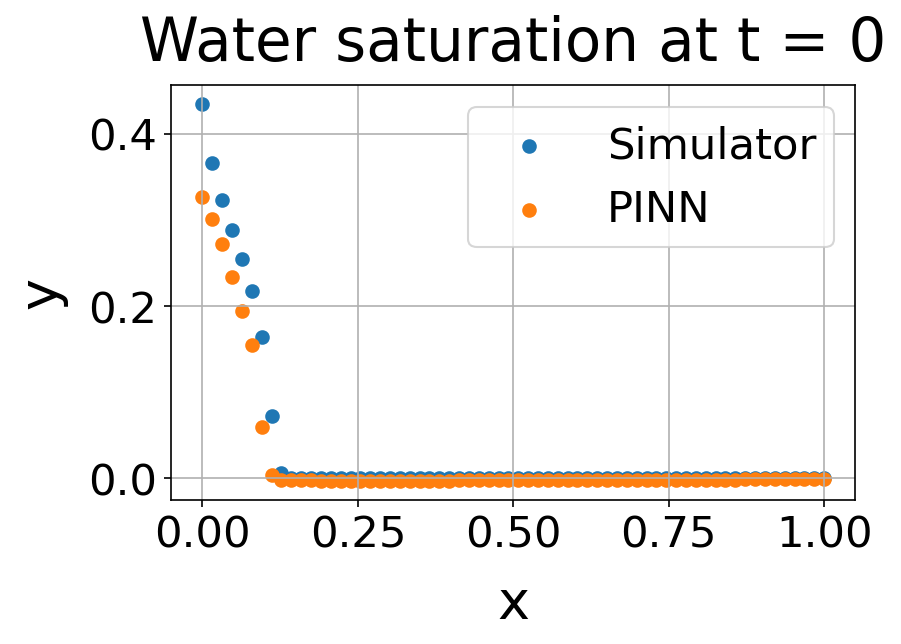

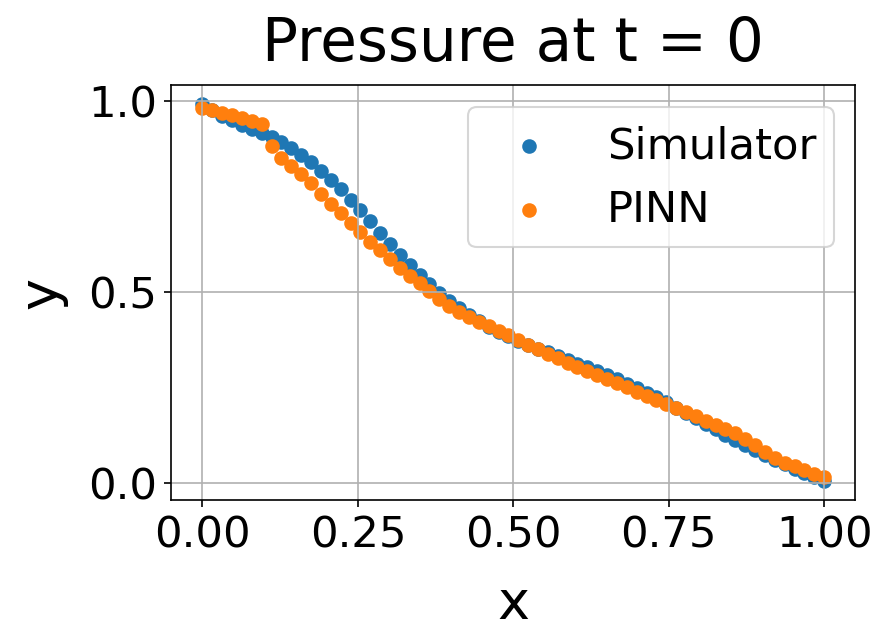

0

In [28]:
main_new(model)

In [31]:
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.26e-1
niter = 100


# swat = np.zeros((nx0, nx1, nx2))
# soil = np.ones((nx0, nx1, nx2))


pres, swat, soil = compute_solution(perm, poro,
                                    dx0, dx1, dx2, dt * niter, niter,
                                    pwat, kwat, poil, koil, vr,
                                    pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
model_prediction = model_prediction.detach().numpy()

In [32]:
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

satur = [
    np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1])),
    r2_score(swat[:, 0, 0, -1], model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2))**0.5
]


press = [
    np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1])),
    r2_score(pres[:, 0, 0, -1], model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2))**0.5
]

In [33]:
data = pd.DataFrame({'Metrics': metrics,
                     'Saturation': satur,
                     'Pressure': press})

In [34]:
data

,Metrics,Saturation,Pressure
0,MSE,0.000225,0.000150
1,MAE,0.003790,0.002427
2,R_2,0.975380,0.998360
3,RMSE,0.014989,0.012246
